In [1]:
import os
import pickle
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Reshape
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



In [2]:
def add_dim(x, shape):
    return np.reshape(x, (1,) + shape)

class QModelGRU:
    def __init__(self, state_shape, n_action):
        self.state_shape = state_shape
        self.n_action = n_action
        self.qmodel = 'GRU'
        self.attr2save = ['state_shape', 'n_action', 'model_name']
        self.init()

    def init(self):
        model = Sequential()
        model.add(GRU(64, input_shape=(1,) + self.state_shape, return_sequences=False))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.n_action, activation='linear'))

        model.compile(loss='mse', optimizer='adam',metrics = ['accuracy'])
        self.model = model
        self.model_name = self.qmodel

    def save(self, fld):
        if not os.path.exists(fld):
            os.makedirs(fld)

        with open(os.path.join(fld, 'model.json'), 'w') as json_file:
            json_file.write(self.model.to_json())
        self.model.save_weights(os.path.join(fld, 'weights.hdf5'))

        attr = {a: getattr(self, a) for a in self.attr2save}
        pickle.dump(attr, open(os.path.join(fld, 'Qmodel_attr.pickle'), 'wb'))

    def load(self, fld):
        json_str = open(os.path.join(fld, 'model.json')).read()
        self.model = keras.models.model_from_json(json_str)
        self.model.load_weights(os.path.join(fld, 'weights.hdf5'))
        self.model.compile(loss='mse', optimizer='adam',metrics = ['accuracy'])

        attr = pickle.load(open(os.path.join(fld, 'Qmodel_attr.pickle'), 'rb'))
        for a in attr:
            setattr(self, a, attr[a])

    def predict(self, state):
        state = add_dim(state, (1,) + self.state_shape)  # Reshape for timesteps
        q = self.model.predict(state)[0]
        

        if np.isnan(max(q)):
            print('state' + str(state))
            print('q' + str(q))
            raise ValueError

        return q

    def fit(self, state, action, q_action):
        q = self.predict(state)
        q[action] = q_action

        # Add an additional time dimension to state and q
        state_with_time = add_dim(state, (1,) + self.state_shape)
        q_with_time = add_dim(q, (1, self.n_action))

        self.model.fit(state_with_time, q_with_time, epochs=1, verbose=0)
    
    def mse(self, states, q_values, verbose = 0):
        predictions = np.array([self.predict(state) for state in states])
        mse = mean_squared_error(q_values, predictions)
        return mse
        


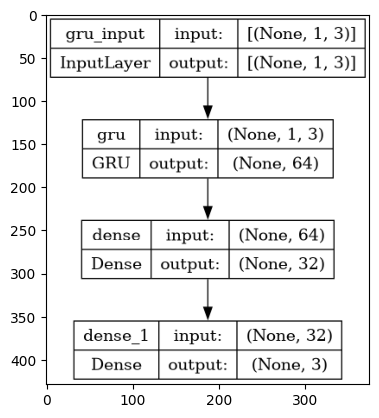

In [3]:
def generate_data(num_samples, temp_range, humidity_range, maintenance_times_range):
    states = []
    actions = []
    q_values = []

    for _ in range(num_samples):
        # Generate random state features
        temperature = np.random.uniform(*temp_range)
        humidity = np.random.uniform(*humidity_range)
        maintenance_time = np.random.uniform(*maintenance_times_range)

        # Action is randomly selected for demonstration purposes
        action = np.random.choice([0, 1, 2])

        # Q-values are generated randomly for demonstration purposes
        q_value = np.random.rand(3)

        # Append NumPy array directly
        states.append(np.array([temperature, humidity, maintenance_time]))
        actions.append(action)
        q_values.append(q_value)

    return np.array(states), np.array(actions), np.array(q_values)

# Parameters
num_samples = 1000
temp_range = (20, 40)
humidity_range = (40, 80)
maintenance_times_range = (1, 365)

# Generate synthetic data
states, actions, q_values = generate_data(num_samples, temp_range, humidity_range, maintenance_times_range)
states_train, states_test, actions_train, actions_test, q_values_train, q_values_test = train_test_split(
    states, actions, q_values, test_size=0.2, random_state=42
)

df = pd.DataFrame({
    'temperature': states[:, 0],
    'humidity': states[:, 1],
    'maintenance_times':states[:,2],
    'action': actions,
    'q_value1': q_values[:, 0],
    'q_value2': q_values[:, 1],
    'q_value3': q_values[:, 2],
})

# Save data to CSV
csv_file_path = 'machine_data.csv'
df.to_csv(csv_file_path, index=False)

# Load your data from CSV
df = pd.read_csv(csv_file_path)


# Extract relevant columns
state_columns = ['temperature', 'humidity','maintenance_times']
action_column = 'action'
q_value_columns = ['q_value1', 'q_value2', 'q_value3']

# Extract data from DataFrame
states = df[state_columns].values
actions = df[action_column].values
q_values = df[q_value_columns].values

# Create QModelGRU
state_shape = states.shape[1:]  # Assuming the shape of each state
n_action = len(q_value_columns)  # Number of actions
q_model = QModelGRU(state_shape, n_action)

# Save and load the model
q_model.save('path_to_save_model_gru')
q_model.load('path_to_save_model_gru')

# Visualize the model architecture
plot_model(q_model.model, to_file='q_model_gru.png', show_shapes=True, show_layer_names=True)

# Display the image
img = plt.imread('q_model_gru.png')
plt.imshow(img)
plt.show()

In [4]:
# Train the model
len(q_values_train)
for i in range(len(q_values_train)):
    for j in range(len(q_values_train[i])):
        q_model.fit(states_train[i], actions_train[i], q_values_train[i, j])


# Save the model
q_model.save('/kaggle/working/path_to_save_model_gru')




1/1 [==============================] - 0s 20ms/step


In [5]:
loaded_q_model = QModelGRU(state_shape, n_action)
loaded_q_model.load('/kaggle/working/path_to_save_model_gru')

# Example prediction
example_state = np.array([[25.0, 60.0, 90]])  # Adjust with your own state
prediction = loaded_q_model.predict(example_state)
print("Q-values for the example state:", prediction)

1/1 [==============================] - 0s 353ms/step
Q-values for the example state: [0.6763505 0.5288023 0.6417709]


In [6]:
mse = q_model.mse(states_test, q_values_test)


1/1 [==============================] - 0s 19ms/step


In [7]:
print(mse)

0.08807476619559447
